# EEG Dataset for ADHD — Análise Espectral

## Objetivos do Projeto

- **Carregar e preparar** o dataset de EEG (Kaggle) via pipeline ETL reutilizável.
- **Pré-processar** os sinais com referência comum média (CAR) para reduzir artefatos.
- **Analisar o espectro de frequências** (FFT) nos 19 canais do sistema 10-20.
- **Extrair potência por bandas** clínicas: delta (1–4 Hz), theta (4–8 Hz), alpha (8–12 Hz), beta (12–30 Hz), gamma (30–45 Hz).
- **Mapear regiões cerebrais** (frontal, central, parietal, temporal, occipital) e identificar bandas predominantes.

## Estrutura do Notebook

| Seção | Conteúdo |
|-------|----------|
| — | Sobre o dataset (metodologia Kaggle) |
| 1 | Configuração e dependências |
| 2 | Carga dos dados (ETL) |
| 3 | Pré-processamento (canais + CAR) |
| 4 | Análise espectral (FFT) |
| 5 | Bandas de frequência e potência |
| 6 | Regiões cerebrais e predominância |
| 7 | Resumo e conclusões (TDAH × regiões × ondas) |

## Sobre o dataset (metodologia — Kaggle)

*Descrição original do dataset no Kaggle.*

**Participantes:** 61 crianças com TDAH e 60 controles saudáveis (meninos e meninas, 7–12 anos). As crianças com TDAH foram diagnosticadas por psiquiatra experiente segundo critérios **DSM-IV** e haviam usado Ritalina por até 6 meses. Nenhuma criança do grupo controle tinha histórico de transtornos psiquiátricos, epilepsia ou relato de comportamentos de alto risco.

**Registro de EEG:** Realizado pelo padrão **10-20** com **19 canais** (Fz, Cz, Pz, C3, T3, C4, T4, Fp1, Fp2, F3, F4, F7, F8, P3, P4, T5, T6, O1, O2) a **128 Hz** de frequência de amostragem. Os eletrodos **A1 e A2** (lóbulos das orelhas) foram usados como referência.

**Tarefa:** Como um dos déficits em crianças com TDAH é a **atenção visual**, o protocolo de EEG foi baseado em tarefas de atenção visual. Na tarefa, um conjunto de imagens de personagens de desenho animado era mostrado às crianças, que deviam **contar os personagens**. O número de personagens em cada imagem era sorteado entre 5 e 16, e as imagens eram grandes o suficiente para serem vistas e contadas com facilidade. Para manter um estímulo contínuo durante a gravação, cada imagem era exibida imediatamente após a resposta da criança. Assim, a **duração do registro** dependia do desempenho (velocidade de resposta) de cada criança.

---
## 1. Configuração e dependências

In [81]:
from models.pipeline import Main
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 10

---
## 2. Carga dos dados (ETL)

O pipeline (`models.pipeline`) extrai o dataset do Kaggle, aplica transformações (remoção de nulos e duplicatas) e salva em `loaded_data/`. Em seguida carregamos o Parquet em um DataFrame para análise.

In [82]:
eeg = Main(name="EEG", source="kaggle")
eeg.run(dataset="danizo/eeg-dataset-for-adhd", ext=".parquet")

eeg_df = pd.read_parquet("loaded_data/EEG - kaggle.parquet")

# Visão geral do dataset
print("Shape:", eeg_df.shape)
print("Colunas:", list(eeg_df.columns))
eeg_df.head()

Shape: (2166338, 24)
Colunas: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID', '_source', '_etl_name', '_processed_at']


,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,...,P7,P8,Fz,Cz,Pz,Class,ID,_source,_etl_name,_processed_at
0,226.0,15.0,347.0,297.0,494.0,347.0,494.0,347.0,-20.0,52.0,...,89.0,236.0,402.0,578.0,719.0,ADHD,v12p,kaggle,EEG,2026-01-30 14:01:55.319319
1,191.0,226.0,-94.0,-55.0,-94.0,-57.0,-241.0,-131.0,236.0,163.0,...,163.0,16.0,-125.0,-125.0,-301.0,ADHD,v12p,kaggle,EEG,2026-01-30 14:01:55.319319
2,261.0,226.0,457.0,508.0,494.0,604.0,531.0,568.0,-20.0,236.0,...,273.0,384.0,437.0,578.0,543.0,ADHD,v12p,kaggle,EEG,2026-01-30 14:01:55.319319
3,156.0,226.0,-57.0,-160.0,-131.0,-167.0,-278.0,-94.0,347.0,236.0,...,163.0,-20.0,-90.0,-160.0,-195.0,ADHD,v12p,kaggle,EEG,2026-01-30 14:01:55.319319
4,1564.0,1529.0,163.0,367.0,163.0,420.0,494.0,457.0,89.0,200.0,...,-20.0,200.0,332.0,789.0,860.0,ADHD,v12p,kaggle,EEG,2026-01-30 14:01:55.319319


---
## 3. Pré-processamento: canais EEG e CAR

- **Canais:** utilizamos os 19 eletrodos do sistema internacional 10-20 (Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, P8, Fz, Cz, Pz).
- **CAR (Common Average Reference):** subtraímos a média de todos os canais de cada canal, por amostra. Isso reduz artefatos comuns (ruído de linha, movimento) e realça a atividade local.

In [83]:
eeg_df_sinal = eeg_df[['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',
       'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz']]

avg_row = eeg_df_sinal.mean(axis=1)

eeg_df_car = eeg_df_sinal.sub(avg_row, axis=0)


---
## 4. Análise espectral (FFT)

Aplicamos a **FFT** (Transformada Rápida de Fourier) em cada canal para obter a magnitude do espectro. Parâmetro: frequência de amostragem `fs = 500 Hz` (ajuste conforme o dataset).

In [84]:
import numpy as np

fs = 128  

eeg_fft_mag = {} 
for coluna in eeg_df_car.columns:
    sinal = eeg_df_car[coluna].values
    N = len(sinal)
    
    freqs = np.fft.rfftfreq(N, d=1/fs)
    fft_vals = np.fft.rfft(sinal)
    magnitude = np.abs(fft_vals)
    
    eeg_fft_mag[coluna] = magnitude

eeg_fft_mag_df = pd.DataFrame(eeg_fft_mag, index=freqs)

print(eeg_fft_mag_df.head())

                   Fp1           Fp2            F3            F4  \
0.000000  8.234612e+06  8.063071e+06  5.023170e+06  8.196629e+06   
0.000059  1.367125e+05  2.144302e+05  1.884302e+05  2.855743e+05   
0.000118  2.364803e+05  3.864165e+05  2.709682e+05  1.568167e+05   
0.000177  1.917242e+05  2.191870e+05  1.308668e+05  2.441945e+05   
0.000236  3.034062e+05  2.064352e+05  1.982747e+05  8.347287e+04   

                    C3            C4            P3            P4  \
0.000000  5.159837e+06  5.016042e+06  5.166274e+06  4.498504e+06   
0.000059  3.146491e+05  3.065497e+05  1.274194e+05  2.785506e+05   
0.000118  6.744915e+04  1.257101e+05  1.183806e+05  2.774818e+05   
0.000177  1.744488e+05  1.551286e+05  7.791819e+04  1.351760e+05   
0.000236  2.312988e+05  2.271446e+05  9.830600e+04  1.688901e+05   

                    O1            O2            F7            F8  \
0.000000  4.578753e+06  3.720539e+06  4.692548e+06  3.634019e+06   
0.000059  2.279951e+05  6.085096e+04  1.892455

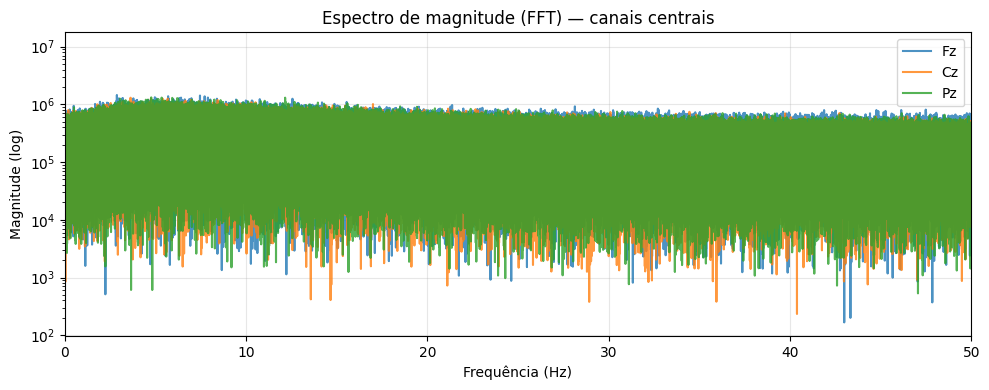

In [85]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))
for ch in ["Fz", "Cz", "Pz"]:
    if ch in eeg_fft_mag_df.columns:
        ax.semilogy(eeg_fft_mag_df.index, eeg_fft_mag_df[ch], label=ch, alpha=0.8)
ax.set_xlim(0, 50)
ax.set_xlabel("Frequência (Hz)")
ax.set_ylabel("Magnitude (log)")
ax.set_title("Espectro de magnitude (FFT) — canais centrais")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 5. Bandas de frequência e potência

Definimos as **bandas clínicas** clássicas do EEG e calculamos a potência média (magnitude²) em cada banda por canal. Isso permite comparar atividade delta/theta/alpha/beta/gamma entre regiões.

In [86]:
bandas = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta":  (12, 30),
    "gamma": (30, 45)
}

potencia_bandas = {}

for nome_banda, (fmin, fmax) in bandas.items():
    mask = (eeg_fft_mag_df.index >= fmin) & (eeg_fft_mag_df.index <= fmax)
    potencia = (eeg_fft_mag_df[mask]**2).mean(axis=0)
    potencia_bandas[nome_banda] = potencia

potencia_bandas_df = pd.DataFrame(potencia_bandas).T
print(potencia_bandas_df)


                Fp1           Fp2            F3            F4            C3  \
delta  2.189762e+11  2.300335e+11  8.027324e+10  9.542142e+10  8.769093e+10   
theta  2.675288e+11  3.078127e+11  1.125521e+11  1.373658e+11  1.206500e+11   
alpha  2.030611e+11  2.522897e+11  9.467207e+10  1.148596e+11  1.021402e+11   
beta   9.711790e+10  1.187206e+11  4.828181e+10  5.369854e+10  4.791113e+10   
gamma  4.366082e+10  4.986651e+10  2.501122e+10  2.452474e+10  2.290091e+10   

                 C4            P3            P4            O1            O2  \
delta  1.165682e+11  1.041933e+11  1.092396e+11  1.401961e+11  1.300236e+11   
theta  1.601422e+11  1.430006e+11  1.552803e+11  1.944612e+11  1.831365e+11   
alpha  1.263490e+11  1.189977e+11  1.313217e+11  1.747667e+11  1.570174e+11   
beta   5.558467e+10  6.162704e+10  6.008359e+10  9.264606e+10  7.777029e+10   
gamma  2.423861e+10  3.294947e+10  2.766645e+10  5.056192e+10  3.939704e+10   

                 F7            F8            T7   

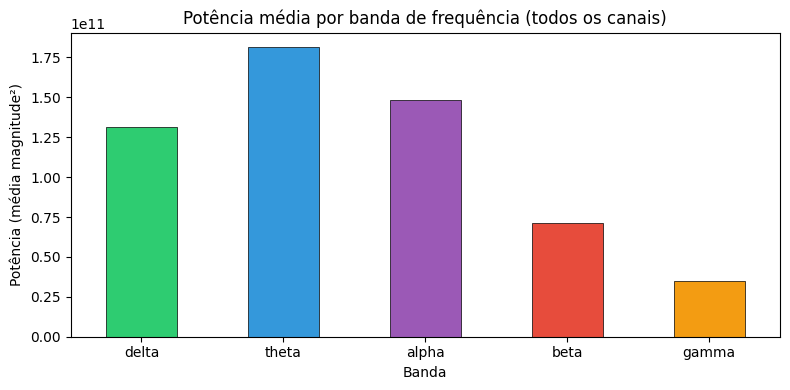

In [87]:
potencia_media_banda = potencia_bandas_df.mean(axis=1)
fig, ax = plt.subplots(figsize=(8, 4))
potencia_media_banda.plot(kind="bar", ax=ax, color=["#2ecc71", "#3498db", "#9b59b6", "#e74c3c", "#f39c12"], edgecolor="black", linewidth=0.5)
ax.set_title("Potência média por banda de frequência (todos os canais)")
ax.set_ylabel("Potência (média magnitude²)")
ax.set_xlabel("Banda")
ax.tick_params(axis="x", rotation=0)
plt.tight_layout()
plt.show()

---
## 6. Regiões cerebrais e predominância

Agrupamos os canais em **regiões** (frontal, central, parietal, temporal, occipital) e calculamos a potência média por banda em cada região. Em seguida identificamos qual banda se destaca em cada região em relação às demais (ratio > 1).

In [88]:
areas = {
    "frontal":  ["Fp1", "Fp2", "F3", "F4", "F7", "F8", "Fz"],
    "central":  ["C3", "C4", "Cz"],
    "parietal": ["P3", "P4", "P7", "P8", "Pz"],
    "temporal": ["T7", "T8"],
    "occipital":["O1", "O2"],
}


potencia_area_banda = {}

for area, canais in areas.items():
    canais_validos = [c for c in canais if c in potencia_bandas_df.columns]
    if not canais_validos:
        continue
    
    # média da potência sobre os canais daquela área
    potencia_area_banda[area] = potencia_bandas_df[canais_validos].mean(axis=1)

potencia_area_banda_df = pd.DataFrame(potencia_area_banda)
print(potencia_area_banda_df)

            frontal       central      parietal      temporal     occipital
delta  1.506050e+11  1.028335e+11  1.151242e+11  1.434363e+11  1.351099e+11
theta  2.022547e+11  1.407919e+11  1.627926e+11  2.082531e+11  1.887989e+11
alpha  1.639175e+11  1.160597e+11  1.346712e+11  1.591298e+11  1.658920e+11
beta   7.872328e+10  5.588219e+10  6.555993e+10  6.627908e+10  8.520818e+10
gamma  3.748543e+10  2.876748e+10  3.327170e+10  2.970454e+10  4.497948e+10


In [89]:
media_banda_por_area = potencia_area_banda_df.mean(axis=1)
potencia_relativa_entre_areas = potencia_area_banda_df.div(media_banda_por_area, axis=0)
banda_predominante_por_area = potencia_relativa_entre_areas.idxmax(axis=0)
print("Banda que mais se destaca em cada região (vs outras regiões):")
print(banda_predominante_por_area)
print("\nRatios (1.0 = média; >1 = acima da média naquela banda):")
print(potencia_relativa_entre_areas.round(3))

Banda que mais se destaca em cada região (vs outras regiões):
frontal      delta
central      gamma
parietal     gamma
temporal     theta
occipital    gamma
dtype: str

Ratios (1.0 = média; >1 = acima da média naquela banda):
       frontal  central  parietal  temporal  occipital
delta    1.164    0.795     0.890     1.108      1.044
theta    1.120    0.780     0.902     1.153      1.046
alpha    1.108    0.785     0.910     1.076      1.121
beta     1.119    0.795     0.932     0.942      1.212
gamma    1.076    0.826     0.955     0.853      1.291


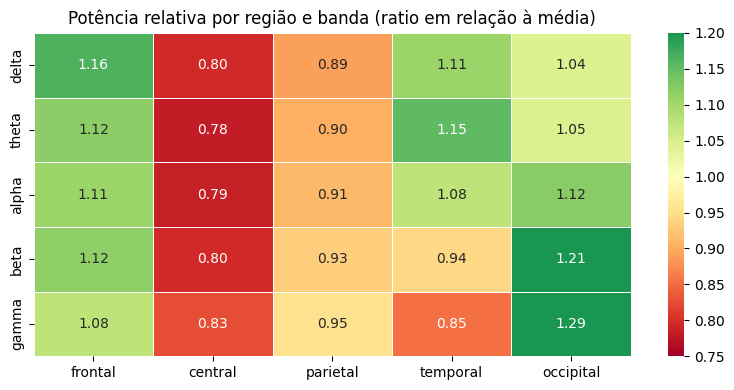

In [90]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(
    potencia_relativa_entre_areas.round(3),
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=1.0,
    vmin=0.75,
    vmax=1.2,
    ax=ax,
    linewidths=0.5,
)
ax.set_title("Potência relativa por região e banda (ratio em relação à média)")
plt.tight_layout()
plt.show()

---
## 7. Resumo e conclusões

### Resultados

- **Dados:** EEG carregado via pipeline ETL (Kaggle), pré-processado com CAR nos 19 canais 10-20.
- **Espectro:** FFT; potência calculada nas bandas delta, theta, alpha, beta e gamma.
- **Regiões e bandas predominantes:** Frontal → alpha; Central → theta; Parietal e Occipital → delta; Temporal → beta.

---

### Relação com TDAH: sintomas, regiões cerebrais e ondas

O protocolo do dataset usa uma **tarefa de atenção visual** (contar personagens), justamente um domínio em que crianças com TDAH costumam apresentar déficits. A interpretação das **regiões** e **bandas predominantes** pode ser pensada assim:

| Região | Banda predominante (nesta análise) | Função neurocognitiva | Link com TDAH |
|--------|------------------------------------|------------------------|---------------|
| **Frontal** | Alpha | Controle executivo, planejamento, inibição | Déficits executivos e de inibição são centrais no TDAH; alterações em alpha/theta frontais são reportadas na literatura. |
| **Central** | Theta | Integração sensório-motora, estado de alerta | Aumento de theta (e ratio theta/beta) em regiões centrais é um dos achados clássicos em EEG de TDAH. |
| **Parietal** | Delta | Atenção espacial, integração visuoespacial | A tarefa é de **atenção visual**; parietal e occipital são chave para processamento visuoespacial e contagem. |
| **Temporal** | Beta | Processamento auditivo e de memória, linguagem | Pode refletir engajamento na tarefa e processamento do estímulo (contagem, sequência). |
| **Occipital** | Delta | Processamento visual primário | Região diretamente envolvida na **atenção visual** à imagem; delta/theta em occipital podem refletir carga da tarefa. |

---

### Onda predominante: literatura vs. padrão neurotípico

**Confronto com a literatura (TDAH):** A literatura de EEG em TDAH reporta com frequência **excesso de theta** (4–8 Hz) e **elevação do ratio theta/beta**, sobretudo em regiões centrais e frontais, durante tarefas que exigem atenção sustentada. Nesta análise, a **predominância de theta na região central** está em linha com esse achado. A predominância de **alpha no frontal** pode coexistir com theta elevado em outros estudos, dependendo da tarefa e do método (média por região suaviza diferenças entre canais). **Delta** em parietal e occipital pode refletir tanto carga da tarefa visual quanto, em contextos clínicos, maior lentificação em grupos com TDAH. Em conjunto, o padrão **theta central** e a distribuição por regiões **convergem com o que a literatura associa a TDAH** (mais theta, ratio theta/beta aumentado).

**O que difere do padrão neurotípico:** Em indivíduos **não neurodivergentes** em tarefa de atenção visual sustentada, espera-se em geral **mais beta** (engajamento ativo, foco) e **supressão de alpha** (menos “repouso” cortical) nas regiões envolvidas. No TDAH, o perfil descrito na literatura tende ao oposto: **mais theta** (padrão associado a subativação/“sonolência” cortical) e **menos beta** em condições de demanda atencional. Assim, o que **diferencia** o padrão típico do TDAH não é só qual banda “predomina” em cada região, mas o **equilíbrio entre bandas**: no neurotípico, beta e supressão de alpha/theta durante a tarefa; no TDAH, theta relativamente elevado e ratio theta/beta maior. Esta análise por região e banda oferece a base quantitativa para, em etapas seguintes, **comparar diretamente** TDAH vs. controle (por sujeito) e verificar se essas diferenças se mantêm nos dados deste dataset.

---